# Intelligent Systems (SInt) - Group Project

## **Fuzzy Data Analysis with Multi-Method Classification for Predicting Heart Disease**

Group No.: 9

Students:
- Pedro Geitoeira, No. 87489
- Eloy Marquesan Dones, No. 112861

**GitHub**: [SInt_G09](https://github.com/pedrogeitoeira/SInt_G09.git)

## Takagi-Sugeno (TS) Fuzzy Model Using **Fuzzy C-Means (FCM)** Clustering

**NOTE**: To ensure full reproducibility, the entire code must be run at once.

### Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from numpy import clip, column_stack, argmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, confusion_matrix
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

### Data Preprocessing

In [23]:
# Load the dataset.
data = pd.read_csv('data/heart_disease.csv')

# Extract the variable names.
var_names = data.columns

# Print the original variable names.
print('Variable names:')
for var in var_names:
    print(var)

Variable names:
age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
target


In [24]:
# Manually provide the updated variable names.
new_var_names = ['Age',
                 'Sex',
                 'ChestPainType',
                 'RestingBloodPressure',
                 'SerumCholesterol',
                 'FastingBloodSugar',
                 'RestingElectrocardiographicResults',
                 'MaximumHeartRateAchieved',
                 'ExerciseInducedAngina',
                 'Oldpeak',
                 'SlopeOfThePeakExerciseSTSegment',
                 'NumberOfMajorVessels',
                 'Thal',
                 'HeartDisease']

# Update the column names in the dataset.
data.columns = new_var_names

# Print the updated variable names.
print('Updated variable names:')
for var in data.columns:
    print(var)

Updated variable names:
Age
Sex
ChestPainType
RestingBloodPressure
SerumCholesterol
FastingBloodSugar
RestingElectrocardiographicResults
MaximumHeartRateAchieved
ExerciseInducedAngina
Oldpeak
SlopeOfThePeakExerciseSTSegment
NumberOfMajorVessels
Thal
HeartDisease


In [25]:
# Check for the presence of NaN values and determine if there are any non-numeric entries.
nan_check = data.isna().sum() # Check for the presence of NaN values.
non_numeric_check = data.apply(lambda col: col.map(lambda x: isinstance(x, str)).sum()) # Check for the presence of string entries.

# Print the number of NaN entries in each variable column.
print('Number of NaN entries in each variable column:')
for column, count in nan_check.items():
    print(f'{column}: {count}')

# Print the number of non-numeric entries in each variable column.
print('\nNumber of non-numeric entries in each variable column:')
for column, count in non_numeric_check.items():
    print(f'{column}: {count}')

Number of NaN entries in each variable column:
Age: 0
Sex: 0
ChestPainType: 0
RestingBloodPressure: 0
SerumCholesterol: 0
FastingBloodSugar: 0
RestingElectrocardiographicResults: 0
MaximumHeartRateAchieved: 0
ExerciseInducedAngina: 0
Oldpeak: 0
SlopeOfThePeakExerciseSTSegment: 0
NumberOfMajorVessels: 0
Thal: 0
HeartDisease: 0

Number of non-numeric entries in each variable column:
Age: 0
Sex: 0
ChestPainType: 0
RestingBloodPressure: 0
SerumCholesterol: 0
FastingBloodSugar: 0
RestingElectrocardiographicResults: 0
MaximumHeartRateAchieved: 0
ExerciseInducedAngina: 0
Oldpeak: 0
SlopeOfThePeakExerciseSTSegment: 0
NumberOfMajorVessels: 0
Thal: 0
HeartDisease: 0


**The dataset appears to be clean**. It does not contain any NaN (missing) values or string (non-numeric) entries in any of the columns. Each entry in the dataset seems to be valid.

In [26]:
# Check for class imbalance.
class_distribution = data['HeartDisease'].value_counts(normalize = True)*100

# Format the class distribution as a percentage with two decimal places.
class_distribution = class_distribution.map('{:.2f}%'.format)

# Print the class distribution.
print('Class distribution:')
for index, value in class_distribution.items():
    print(f'{index}: {value}')

Class distribution:
1: 51.32%
0: 48.68%


**The dataset does not exhibit significant class imbalance**. The distribution between the two classes (1 and 0) is nearly even, indicating that special techniques, such as resampling (oversampling or undersampling) or class weighting, are unlikely to be necessary for handling class imbalance during the modeling process.

In [27]:
# Extract the feature names.
feature_names = data.columns[:-1]

# Convert the dataset to a numpy array.
data = data.to_numpy()

# Normalize the dataset to the range [0, 1].
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Assign the X and y for the classification problem.
X = data[:, :-1] # All columns except the last one as input features.
y = data[:, -1] # The last column as the target (Heart Disease).

# Split the dataset into training and testing sets while preserving class distribution.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

**The dataset was normalized to a range of 0 to 1 to ensure features are on comparable scales**. Takagi-Sugeno fuzzy models require consistent feature values to prevent distorted membership values and poor cluster formation. Clustering methods like **Fuzzy C-Means (FCM)** rely on distance metrics that are sensitive to feature scales, so normalization prevents features with larger ranges from dominating, ensuring balanced fuzzy rules and accurate memberships.

**The dataset was split into training and testing sets using an 80%-20% ratio**. **Stratification was applied during the split** to ensure that the class distribution was maintained across both sets.

### Model Training and Cross-Validation

In [28]:
# Set up the stratified k-fold cross-validation on the training set.
k = 5 # Number of folds.
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42) # 5-fold stratified cross-validation.

# Define the range of cluster numbers to evaluate during training and validation.
cluster_range = range(2, 9) # Range of cluster numbers from 2 to 8.

**Cross-validation** aims to assess a model’s ability to generalize to new, unseen data by splitting the dataset (in this case, the original training set) into training and validation subsets. It helps **select the best hyperparameters**, **detect overfitting**, and **provide a reliable estimate of model performance**. Specifically, **5-fold stratified cross-validation was used to maintain class distribution across each of the five folds**. This approach ensures that the model's performance metrics are representative and reduces variance and bias, leading to a more robust and fair evaluation of its ability to generalize.

**To determine the optimal cluster number**, where the best estimated model performance (validation performance) is achieved, **a 5-fold stratified cross-validation was applied across a range of cluster numbers**.

#### Without Feature Selection

In [29]:
# Initialize the lists to store the mean training and validation performance metrics for the different cluster numbers.
mean_acc_train_all = [] # Mean training accuracy.
mean_rec_train_all = [] # Mean training recall.
mean_prec_train_all = [] # Mean training precision.
mean_F1_score_train_all = [] # Mean training F1-score.
mean_kappa_train_all = [] # Mean training Cohen's kappa.
mean_acc_val_all = [] # Mean validation accuracy.
mean_rec_val_all = [] # Mean validation recall.
mean_prec_val_all = [] # Mean validation precision.
mean_F1_score_val_all = [] # Mean validation F1-score.
mean_kappa_val_all = [] # Mean validation Cohen's kappa.

# Initialize the lists to store the standard deviation of the training and validation performance metrics
# for the different cluster numbers.
std_acc_train_all = [] # Standard deviation of the training accuracy.
std_rec_train_all = [] # Standard deviation of the training recall.
std_prec_train_all = [] # Standard deviation of the training precision.
std_F1_score_train_all = [] # Standard deviation of the training F1-score.
std_kappa_train_all = [] # Standard deviation of the training Cohen's kappa.
std_acc_val_all = [] # Standard deviation of the validation accuracy.
std_rec_val_all = [] # Standard deviation of the validation recall.
std_prec_val_all = [] # Standard deviation of the validation precision.
std_F1_score_val_all = [] # Standard deviation of the validation F1-score.
std_kappa_val_all = [] # Standard deviation of the validation Cohen's kappa.

# Loop over the different cluster numbers.
for nr_clusters in cluster_range:
    # Initialize the lists to store the training and validation performance metrics for each fold iteration.
    acc_train_list = [] # Training accuracy.
    rec_train_list = [] # Training recall.
    prec_train_list = [] # Training precision.
    F1_score_train_list = [] # Training F1-score.
    kappa_train_list = [] # Training Cohen's kappa.
    acc_val_list = [] # Validation accuracy.
    rec_val_list = [] # Validation recall.
    prec_val_list = [] # Validation precision.
    F1_score_val_list = [] # Validation F1-score.
    kappa_val_list = [] # Validation Cohen's kappa.

    # Print the cluster number.
    print(f'Number of clusters: {nr_clusters}\n')

    # Perform the stratified k-fold cross-validation on the training set.
    for fold_itr, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start = 1):
        # Print the fold iteration.
        print(f'Fold iteration {fold_itr}:')

        # Split the training set into training and validation folds for this fold iteration.
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Cluster the input-output space.
        np.random.seed(42) # Set the random seed to ensure reproducibility for the clustering algorithm.
        cl = Clusterer(x_train = X_train_fold, y_train = y_train_fold, nr_clus = nr_clusters)
        clust_centers, part_matrix, _ = cl.cluster(method = 'fcm') # Using the Fuzzy C-Means clustering algorithm.

        # Estimate the membership functions parameters.
        ae = AntecedentEstimator(X_train_fold, part_matrix)
        antecedent_params = ae.determineMF()

        # Estimate the consequent parameters.
        ce = ConsequentEstimator(X_train_fold, y_train_fold, part_matrix)
        conseq_params = ce.suglms()

        # Build the first-order Takagi-Sugeno model.
        modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, feature_names, save_simpful_code = False)
        model = modbuilder.get_model()

        # Get the model predictions on the training set for this fold iteration.
        modtester_train = SugenoFISTester(model, X_train_fold, feature_names)
        y_train_pred_probs = clip(modtester_train.predict()[0], 0, 1)
        y_train_pred_probs = column_stack((1 - y_train_pred_probs, y_train_pred_probs))
        y_train_pred = argmax(y_train_pred_probs, axis = 1)

        # Compute the training performance metrics for this fold iteration.
        acc_train_list.append(accuracy_score(y_train_fold, y_train_pred))
        rec_train_list.append(recall_score(y_train_fold, y_train_pred))
        prec_train_list.append(precision_score(y_train_fold, y_train_pred))
        F1_score_train_list.append(f1_score(y_train_fold, y_train_pred))
        kappa_train_list.append(cohen_kappa_score(y_train_fold, y_train_pred))

        # Get the model predictions on the validation set for this fold iteration.
        modtester_val = SugenoFISTester(model, X_val_fold, feature_names)
        y_val_pred_probs = clip(modtester_val.predict()[0], 0, 1)
        y_val_pred_probs = column_stack((1 - y_val_pred_probs, y_val_pred_probs))
        y_val_pred = argmax(y_val_pred_probs, axis = 1)

        # Compute the validation performance metrics for this fold iteration.
        acc_val_list.append(accuracy_score(y_val_fold, y_val_pred))
        rec_val_list.append(recall_score(y_val_fold, y_val_pred))
        prec_val_list.append(precision_score(y_val_fold, y_val_pred))
        F1_score_val_list.append(f1_score(y_val_fold, y_val_pred))
        kappa_val_list.append(cohen_kappa_score(y_val_fold, y_val_pred))

    # Compute the mean training and validation performance metrics across all fold iterations for this cluster number.
    mean_acc_train_all.append(np.mean(acc_train_list))
    mean_rec_train_all.append(np.mean(rec_train_list))
    mean_prec_train_all.append(np.mean(prec_train_list))
    mean_F1_score_train_all.append(np.mean(F1_score_train_list))
    mean_kappa_train_all.append(np.mean(kappa_train_list))
    mean_acc_val_all.append(np.mean(acc_val_list))
    mean_rec_val_all.append(np.mean(rec_val_list))
    mean_prec_val_all.append(np.mean(prec_val_list))
    mean_F1_score_val_all.append(np.mean(F1_score_val_list))
    mean_kappa_val_all.append(np.mean(kappa_val_list))

    # Compute the standard deviation of the training and validation performance metrics across all fold iterations
    # for this cluster number.
    std_acc_train_all.append(np.std(acc_train_list))
    std_rec_train_all.append(np.std(rec_train_list))
    std_prec_train_all.append(np.std(prec_train_list))
    std_F1_score_train_all.append(np.std(F1_score_train_list))
    std_kappa_train_all.append(np.std(kappa_train_list))
    std_acc_val_all.append(np.std(acc_val_list))
    std_rec_val_all.append(np.std(rec_val_list))
    std_prec_val_all.append(np.std(prec_val_list))
    std_F1_score_val_all.append(np.std(F1_score_val_list))
    std_kappa_val_all.append(np.std(kappa_val_list))

    # Print the mean and the standard deviation of the training and validation performance metrics for this cluster number.
    print('\nAverage performance metrics (training):')
    print(f'- Accuracy: {mean_acc_train_all[-1]:.3f} ± {std_acc_train_all[-1]:.3f}')
    print(f'- Recall: {mean_rec_train_all[-1]:.3f} ± {std_rec_train_all[-1]:.3f}')
    print(f'- Precision: {mean_prec_train_all[-1]:.3f} ± {std_prec_train_all[-1]:.3f}')
    print(f'- F1-Score: {mean_F1_score_train_all[-1]:.3f} ± {std_F1_score_train_all[-1]:.3f}')
    print(f'- Kappa: {mean_kappa_train_all[-1]:.3f} ± {std_kappa_train_all[-1]:.3f}')
    print('\nAverage performance metrics (validation):')
    print(f'- Accuracy: {mean_acc_val_all[-1]:.3f} ± {std_acc_val_all[-1]:.3f}')
    print(f'- Recall: {mean_rec_val_all[-1]:.3f} ± {std_rec_val_all[-1]:.3f}')
    print(f'- Precision: {mean_prec_val_all[-1]:.3f} ± {std_prec_val_all[-1]:.3f}')
    print(f'- F1-Score: {mean_F1_score_val_all[-1]:.3f} ± {std_F1_score_val_all[-1]:.3f}')
    print(f'- Kappa: {mean_kappa_val_all[-1]:.3f} ± {std_kappa_val_all[-1]:.3f}')
    print('-'*50)

Number of clusters: 2

Fold iteration 1:


 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 2:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 3:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 4:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 5:
 * Detected 2 rules / clusters
 * Detected Sugeno model type

Average performance metrics (training):
- Accuracy: 0.844 ± 0.010
- Recall: 0.916 ± 0.009
- Precision: 0.806 ± 0.009
- F1-Score: 0.858 ± 0.009
- Kappa: 0.686 ± 0.019

Average performance metrics (validation):
- Accuracy: 0.839 ± 0.010
- Recall: 0.910 ± 0.016
- Precision: 0.803 ± 0.018
- F1-Score: 0.853 ± 0.008
- Kappa: 0.677 ± 0.020
--------------------------------------------------
Number of clusters: 3

Fold iteration 1:
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Fold iteration 2:
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Fold iteration 3:
 * Detected 3 rules / clusters
 * Det

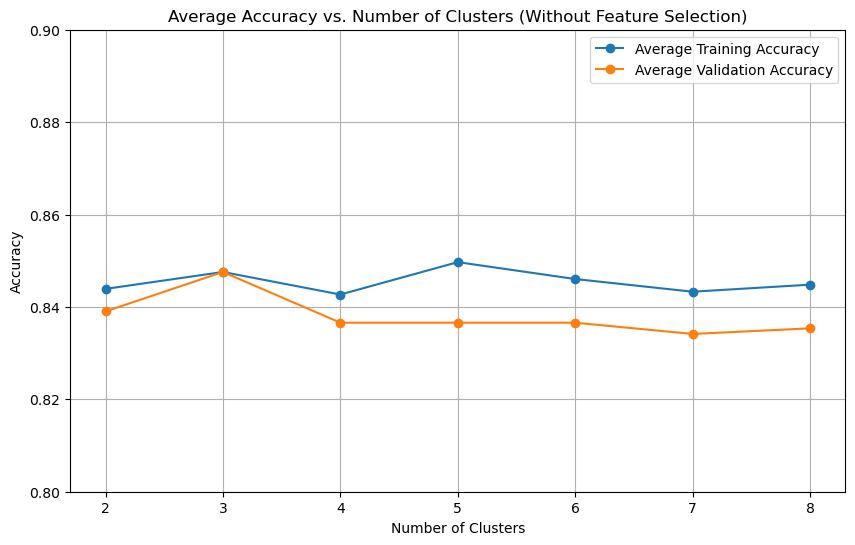

In [30]:
# Plot the mean training and validation accuracies for the different cluster numbers.
plt.figure(figsize = (10, 6))
plt.plot(cluster_range, mean_acc_train_all, label = 'Average Training Accuracy', marker = 'o')
plt.plot(cluster_range, mean_acc_val_all, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(cluster_range)
plt.ylim(0.8, 0.9)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Number of Clusters (Without Feature Selection)')
plt.legend()
plt.grid(True)
plt.show()

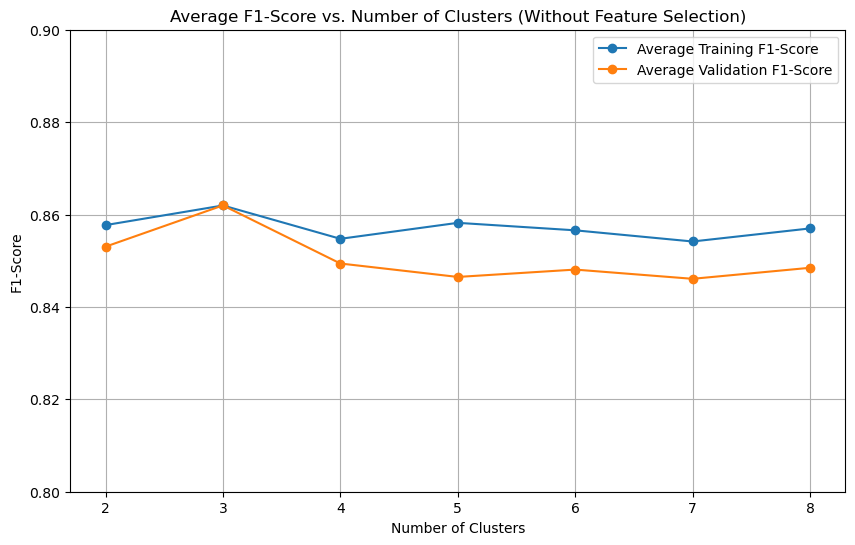

In [31]:
# Plot the mean training and validation F1-scores for the different cluster numbers.
plt.figure(figsize = (10, 6))
plt.plot(cluster_range, mean_F1_score_train_all, label = 'Average Training F1-Score', marker = 'o')
plt.plot(cluster_range, mean_F1_score_val_all, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(cluster_range)
plt.ylim(0.8, 0.9)
plt.xlabel('Number of Clusters')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Number of Clusters (Without Feature Selection)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Initialize a dictionary to store the best-performing cluster number based on each validation performance metric.
best_models_full = {}

# Create a dictionary containing the mean and the standard deviation of the validation performance metrics
# for the different cluster numbers.
metrics_dict_full = {'Accuracy': (mean_acc_val_all, std_acc_val_all),
                     'Recall': (mean_rec_val_all, std_rec_val_all),
                     'Precision': (mean_prec_val_all, std_prec_val_all),
                     'F1-Score': (mean_F1_score_val_all, std_F1_score_val_all),
                     'Kappa': (mean_kappa_val_all, std_kappa_val_all)}

# Loop through each validation performance metric to find the cluster number with the highest mean value.
for metric_name, (mean_values, std_values) in metrics_dict_full.items():
    best_index = np.argmax(mean_values)
    best_nr_clusters = cluster_range[best_index]
    best_models_full[metric_name] = best_nr_clusters

# Print the best model based on each validation performance metric.
for metric_name, best_nr_clusters in best_models_full.items():
    best_index = cluster_range.index(best_nr_clusters)

    print(f'Best model based on validation {metric_name}:')
    print(f'- Number of clusters: {best_nr_clusters}')
    for m_name, (mean_values, std_values) in metrics_dict_full.items():
        print(f'- {m_name}: {mean_values[best_index]:.3f} ± {std_values[best_index]:.3f}')
    print('')

Best model based on validation Accuracy:
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Recall:
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Precision:
- Number of clusters: 5
- Accuracy: 0.837 ± 0.026
- Recall: 0.879 ± 0.039
- Precision: 0.818 ± 0.029
- F1-Score: 0.846 ± 0.025
- Kappa: 0.672 ± 0.052

Best model based on validation F1-Score:
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Kappa:
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031



#### With Feature Selection

In [33]:
# Set up the number of selected features to retain.
nr_selected_features = 9 # Number of selected features.

# Initialize a dictionary to store the 9 most frequently selected features for the different cluster numbers.
top_features_all = {}

# Initialize the lists to store the mean training and validation performance metrics for the different cluster numbers.
mean_acc_train_all = [] # Mean training accuracy.
mean_rec_train_all = [] # Mean training recall.
mean_prec_train_all = [] # Mean training precision.
mean_F1_score_train_all = [] # Mean training F1-score.
mean_kappa_train_all = [] # Mean training Cohen's kappa.
mean_acc_val_all = [] # Mean validation accuracy.
mean_rec_val_all = [] # Mean validation recall.
mean_prec_val_all = [] # Mean validation precision.
mean_F1_score_val_all = [] # Mean validation F1-score.
mean_kappa_val_all = [] # Mean validation Cohen's kappa.

# Initialize the lists to store the standard deviation of the training and validation performance metrics
# for the different cluster numbers.
std_acc_train_all = [] # Standard deviation of the training accuracy.
std_rec_train_all = [] # Standard deviation of the training recall.
std_prec_train_all = [] # Standard deviation of the training precision.
std_F1_score_train_all = [] # Standard deviation of the training F1-score.
std_kappa_train_all = [] # Standard deviation of the training Cohen's kappa.
std_acc_val_all = [] # Standard deviation of the validation accuracy.
std_rec_val_all = [] # Standard deviation of the validation recall.
std_prec_val_all = [] # Standard deviation of the validation precision.
std_F1_score_val_all = [] # Standard deviation of the validation F1-score.
std_kappa_val_all = [] # Standard deviation of the validation Cohen's kappa.

# Loop over the different cluster numbers.
for nr_clusters in cluster_range:
    # Initialize a list to store the selected features for each fold iteration.
    selected_features_idx_list = []

    # Initialize the lists to store the training and validation performance metrics for each fold iteration.
    acc_train_list = [] # Training accuracy.
    rec_train_list = [] # Training recall.
    prec_train_list = [] # Training precision.
    F1_score_train_list = [] # Training F1-score.
    kappa_train_list = [] # Training Cohen's kappa.
    acc_val_list = [] # Validation accuracy.
    rec_val_list = [] # Validation recall.
    prec_val_list = [] # Validation precision.
    F1_score_val_list = [] # Validation F1-score.
    kappa_val_list = [] # Validation Cohen's kappa.

    # Print the cluster number.
    print(f'Number of clusters: {nr_clusters}\n')

    # Perform the stratified k-fold cross-validation on the training set.
    for fold_itr, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start = 1):
        # Print the fold iteration.
        print(f'Fold iteration {fold_itr}:')

        # Split the training set into training and validation folds for this fold iteration.
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # # Select the top 9 features based on the ANOVA F-test with the target variable.
        # feature_selector = SelectKBest(f_classif, k = nr_selected_features)

        # Select the top 9 features based on the Mutual Information (MI) with the target variable.
        feature_selector = SelectKBest(mutual_info_classif, k = nr_selected_features)

        # Fit the feature selector on the training fold and transform the data.
        X_train_fold = feature_selector.fit_transform(X_train_fold, y_train_fold)

        # Transform the validation fold using the same selected features.
        X_val_fold = feature_selector.transform(X_val_fold)

        # Store the selected features for this fold iteration.
        selected_feature_idx = feature_selector.get_support(indices = True).tolist()
        selected_features_idx_list.extend(selected_feature_idx)

        # Extract the selected feature names.
        selected_feature_names = [feature_names[i] for i in selected_feature_idx]

        # Cluster the input-output space.
        np.random.seed(42) # Set the random seed to ensure reproducibility for the clustering algorithm.
        cl = Clusterer(x_train = X_train_fold, y_train = y_train_fold, nr_clus = nr_clusters)
        clust_centers, part_matrix, _ = cl.cluster(method = 'fcm') # Using the Fuzzy C-Means clustering algorithm.

        # Estimate the membership functions parameters.
        ae = AntecedentEstimator(X_train_fold, part_matrix)
        antecedent_params = ae.determineMF()

        # Estimate the consequent parameters.
        ce = ConsequentEstimator(X_train_fold, y_train_fold, part_matrix)
        conseq_params = ce.suglms()

        # Build the first-order Takagi-Sugeno model.
        modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, selected_feature_names,
                                      save_simpful_code = False)
        model = modbuilder.get_model()

        # Get the model predictions on the training set for this fold iteration.
        modtester_train = SugenoFISTester(model, X_train_fold, selected_feature_names)
        y_train_pred_probs = clip(modtester_train.predict()[0], 0, 1)
        y_train_pred_probs = column_stack((1 - y_train_pred_probs, y_train_pred_probs))
        y_train_pred = argmax(y_train_pred_probs, axis = 1)

        # Compute the training performance metrics for this fold iteration.
        acc_train_list.append(accuracy_score(y_train_fold, y_train_pred))
        rec_train_list.append(recall_score(y_train_fold, y_train_pred))
        prec_train_list.append(precision_score(y_train_fold, y_train_pred))
        F1_score_train_list.append(f1_score(y_train_fold, y_train_pred))
        kappa_train_list.append(cohen_kappa_score(y_train_fold, y_train_pred))

        # Get the model predictions on the validation set for this fold iteration.
        modtester_val = SugenoFISTester(model, X_val_fold, selected_feature_names)
        y_val_pred_probs = clip(modtester_val.predict()[0], 0, 1)
        y_val_pred_probs = column_stack((1 - y_val_pred_probs, y_val_pred_probs))
        y_val_pred = argmax(y_val_pred_probs, axis = 1)

        # Compute the validation performance metrics for this fold iteration.
        acc_val_list.append(accuracy_score(y_val_fold, y_val_pred))
        rec_val_list.append(recall_score(y_val_fold, y_val_pred))
        prec_val_list.append(precision_score(y_val_fold, y_val_pred))
        F1_score_val_list.append(f1_score(y_val_fold, y_val_pred))
        kappa_val_list.append(cohen_kappa_score(y_val_fold, y_val_pred))
    
    # Analyze the frequency of the selected features across all fold iterations for this cluster number.
    feature_selection_frequencies = Counter(selected_features_idx_list)

    # Extract and store the 9 most frequently selected features for this cluster number.
    top_features = [feature for feature, _ in feature_selection_frequencies.most_common(nr_selected_features)]
    top_features_all[nr_clusters] = sorted(top_features) # Store them in the dictionary.

    # Compute the mean training and validation performance metrics across all fold iterations for this cluster number.
    mean_acc_train_all.append(np.mean(acc_train_list))
    mean_rec_train_all.append(np.mean(rec_train_list))
    mean_prec_train_all.append(np.mean(prec_train_list))
    mean_F1_score_train_all.append(np.mean(F1_score_train_list))
    mean_kappa_train_all.append(np.mean(kappa_train_list))
    mean_acc_val_all.append(np.mean(acc_val_list))
    mean_rec_val_all.append(np.mean(rec_val_list))
    mean_prec_val_all.append(np.mean(prec_val_list))
    mean_F1_score_val_all.append(np.mean(F1_score_val_list))
    mean_kappa_val_all.append(np.mean(kappa_val_list))

    # Compute the standard deviation of the training and validation performance metrics across all fold iterations
    # for this cluster number.
    std_acc_train_all.append(np.std(acc_train_list))
    std_rec_train_all.append(np.std(rec_train_list))
    std_prec_train_all.append(np.std(prec_train_list))
    std_F1_score_train_all.append(np.std(F1_score_train_list))
    std_kappa_train_all.append(np.std(kappa_train_list))
    std_acc_val_all.append(np.std(acc_val_list))
    std_rec_val_all.append(np.std(rec_val_list))
    std_prec_val_all.append(np.std(prec_val_list))
    std_F1_score_val_all.append(np.std(F1_score_val_list))
    std_kappa_val_all.append(np.std(kappa_val_list))

    # Print the names of the 9 most frequently selected features for this cluster number.
    top_feature_names = [feature_names[i] for i in sorted(top_features)]
    print(f'\n{nr_selected_features} most frequently selected features:')
    for feature in top_feature_names:
        print(f'- {feature}')

    # Print the mean and the standard deviation of the training and validation performance metrics for this cluster number.
    print('\nAverage performance metrics (training):')
    print(f'- Accuracy: {mean_acc_train_all[-1]:.3f} ± {std_acc_train_all[-1]:.3f}')
    print(f'- Recall: {mean_rec_train_all[-1]:.3f} ± {std_rec_train_all[-1]:.3f}')
    print(f'- Precision: {mean_prec_train_all[-1]:.3f} ± {std_prec_train_all[-1]:.3f}')
    print(f'- F1-Score: {mean_F1_score_train_all[-1]:.3f} ± {std_F1_score_train_all[-1]:.3f}')
    print(f'- Kappa: {mean_kappa_train_all[-1]:.3f} ± {std_kappa_train_all[-1]:.3f}')
    print('\nAverage performance metrics (validation):')
    print(f'- Accuracy: {mean_acc_val_all[-1]:.3f} ± {std_acc_val_all[-1]:.3f}')
    print(f'- Recall: {mean_rec_val_all[-1]:.3f} ± {std_rec_val_all[-1]:.3f}')
    print(f'- Precision: {mean_prec_val_all[-1]:.3f} ± {std_prec_val_all[-1]:.3f}')
    print(f'- F1-Score: {mean_F1_score_val_all[-1]:.3f} ± {std_F1_score_val_all[-1]:.3f}')
    print(f'- Kappa: {mean_kappa_val_all[-1]:.3f} ± {std_kappa_val_all[-1]:.3f}')
    print('-'*50)

Number of clusters: 2

Fold iteration 1:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 2:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 3:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 4:
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Fold iteration 5:
 * Detected 2 rules / clusters
 * Detected Sugeno model type

9 most frequently selected features:
- Age
- ChestPainType
- RestingBloodPressure
- SerumCholesterol
- MaximumHeartRateAchieved
- ExerciseInducedAngina
- Oldpeak
- NumberOfMajorVessels
- Thal

Average performance metrics (training):
- Accuracy: 0.839 ± 0.013
- Recall: 0.891 ± 0.019
- Precision: 0.813 ± 0.009
- F1-Score: 0.850 ± 0.013
- Kappa: 0.677 ± 0.026

Average performance metrics (validation):
- Accuracy: 0.833 ± 0.026
- Recall: 0.886 ± 0.022
- Precision: 0.808 ± 0.030
- F1-Score: 0.845 ± 0.023
- Kappa: 0.665 ± 0.053
--------------------------------------------------
Nu

**Feature selection was performed during cross-validation, specifically on the training set of each fold iteration**. This prevents the model from indirectly learning from the validation set, avoids data leakage, and provides an unbiased estimate of model performance. Add something more about the choosen feature selection method ANOVA vs MI...

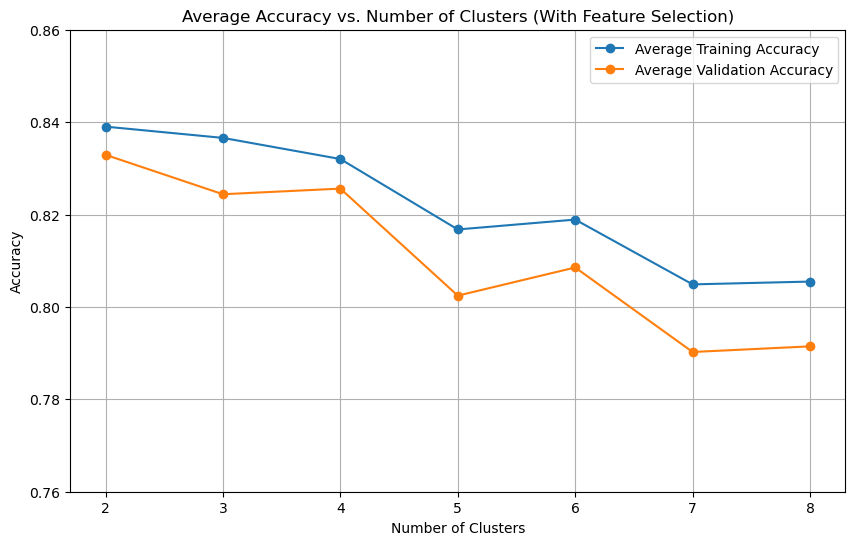

In [34]:
# Plot the mean training and validation accuracies for the different cluster numbers.
plt.figure(figsize = (10, 6))
plt.plot(cluster_range, mean_acc_train_all, label = 'Average Training Accuracy', marker = 'o')
plt.plot(cluster_range, mean_acc_val_all, label = 'Average Validation Accuracy', marker = 'o')
plt.xticks(cluster_range)
plt.ylim(0.76, 0.86)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs. Number of Clusters (With Feature Selection)')
plt.legend()
plt.grid(True)
plt.show()

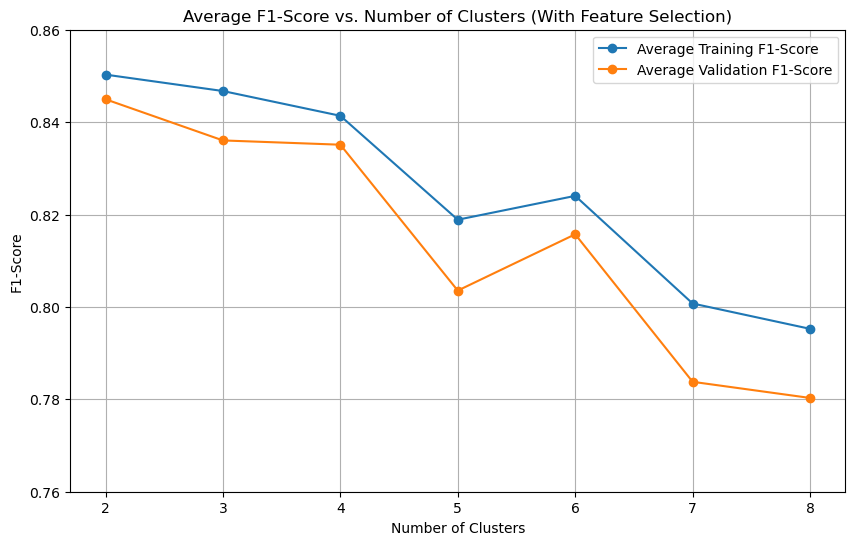

In [35]:
# Plot the mean training and validation F1-scores for the different cluster numbers.
plt.figure(figsize = (10, 6))
plt.plot(cluster_range, mean_F1_score_train_all, label = 'Average Training F1-Score', marker = 'o')
plt.plot(cluster_range, mean_F1_score_val_all, label = 'Average Validation F1-Score', marker = 'o')
plt.xticks(cluster_range)
plt.ylim(0.76, 0.86)
plt.xlabel('Number of Clusters')
plt.ylabel('F1-Score')
plt.title('Average F1-Score vs. Number of Clusters (With Feature Selection)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Initialize a dictionary to store the best-performing cluster number based on each validation performance metric.
best_models_fs = {}

# Create a dictionary containing the mean and the standard deviation of the validation performance metrics
# for the different cluster numbers.
metrics_dict_fs = {'Accuracy': (mean_acc_val_all, std_acc_val_all),
                   'Recall': (mean_rec_val_all, std_rec_val_all),
                   'Precision': (mean_prec_val_all, std_prec_val_all),
                   'F1-Score': (mean_F1_score_val_all, std_F1_score_val_all),
                   'Kappa': (mean_kappa_val_all, std_kappa_val_all)}

# Loop through each validation performance metric to find the cluster number with the highest mean value.
for metric_name, (mean_values, std_values) in metrics_dict_fs.items():
    best_index = np.argmax(mean_values)
    best_nr_clusters = cluster_range[best_index]
    best_models_fs[metric_name] = best_nr_clusters

# Print the best model based on each validation performance metric.
for metric_name, best_nr_clusters in best_models_fs.items():
    best_index = cluster_range.index(best_nr_clusters)

    print(f'Best model based on validation {metric_name}:')
    print(f'- Number of clusters: {best_nr_clusters}')
    for m_name, (mean_values, std_values) in metrics_dict_fs.items():
        print(f'- {m_name}: {mean_values[best_index]:.3f} ± {std_values[best_index]:.3f}')
    print('')

Best model based on validation Accuracy:
- Number of clusters: 2
- Accuracy: 0.833 ± 0.026
- Recall: 0.886 ± 0.022
- Precision: 0.808 ± 0.030
- F1-Score: 0.845 ± 0.023
- Kappa: 0.665 ± 0.053

Best model based on validation Recall:
- Number of clusters: 2
- Accuracy: 0.833 ± 0.026
- Recall: 0.886 ± 0.022
- Precision: 0.808 ± 0.030
- F1-Score: 0.845 ± 0.023
- Kappa: 0.665 ± 0.053

Best model based on validation Precision:
- Number of clusters: 7
- Accuracy: 0.790 ± 0.023
- Recall: 0.743 ± 0.047
- Precision: 0.832 ± 0.031
- F1-Score: 0.784 ± 0.028
- Kappa: 0.581 ± 0.046

Best model based on validation F1-Score:
- Number of clusters: 2
- Accuracy: 0.833 ± 0.026
- Recall: 0.886 ± 0.022
- Precision: 0.808 ± 0.030
- F1-Score: 0.845 ± 0.023
- Kappa: 0.665 ± 0.053

Best model based on validation Kappa:
- Number of clusters: 2
- Accuracy: 0.833 ± 0.026
- Recall: 0.886 ± 0.022
- Precision: 0.808 ± 0.030
- F1-Score: 0.845 ± 0.023
- Kappa: 0.665 ± 0.053



#### Selecting and Training the Final Model

In [37]:
# Initialize a dictionary to store the best model between the full feature set and the selected feature set
# based on each validation performance metric.
best_models = {}

# Loop through each validation performance metric to compare the best models from the full feature set
# and the selected feature set based on the mean values.
for metric_name in metrics_dict_fs.keys():
    # Extract the best cluster number in both the full feature set and the selected feature set scenarios
    # for this validation performance metric.
    full_nr_clusters = best_models_full[metric_name]
    fs_nr_clusters = best_models_fs[metric_name]

    # Extract the means of the validation performance metrics for the best cluster number in both the full feature set
    # and the selected feature set scenarios for this validation performance metric.
    full_mean = metrics_dict_full[metric_name][0][cluster_range.index(full_nr_clusters)]
    fs_mean = metrics_dict_fs[metric_name][0][cluster_range.index(fs_nr_clusters)]

    # Choose the best model based on the highest mean value for this validation performance metric; in case
    # of a tie, use the lowest standard deviation.
    if full_mean > fs_mean:
        best_models[metric_name] = ('Full Feature Set', full_nr_clusters)
    elif fs_mean > full_mean:
        best_models[metric_name] = (f'{nr_selected_features} Features (Feature Selection)', fs_nr_clusters)
    else:
        # If the mean values are equal, choose the model with the lower standard deviation.
        full_std = metrics_dict_full[metric_name][1][cluster_range.index(full_nr_clusters)]
        fs_std = metrics_dict_fs[metric_name][1][cluster_range.index(fs_nr_clusters)]
        if full_std < fs_std:
            best_models[metric_name] = ('Full Feature Set', full_nr_clusters)
        else:
            best_models[metric_name] = (f'{nr_selected_features} Features (Feature Selection)', fs_nr_clusters)

# Print the final best model based on each validation performance metric.
for metric_name, (feature_set_type, best_nr_clusters) in best_models.items():
    best_index = cluster_range.index(best_nr_clusters)
    if feature_set_type == 'Full Feature Set':
        metrics_dict = metrics_dict_full
    else:
        metrics_dict = metrics_dict_fs

    print(f'Best model based on validation {metric_name}:')
    print(f'- Feature set: {feature_set_type}')
    print(f'- Number of clusters: {best_nr_clusters}')
    for m_name, (mean_values, std_values) in metrics_dict.items():
        print(f'- {m_name}: {mean_values[best_index]:.3f} ± {std_values[best_index]:.3f}')
    print('')

Best model based on validation Accuracy:
- Feature set: Full Feature Set
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Recall:
- Feature set: Full Feature Set
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Precision:
- Feature set: 9 Features (Feature Selection)
- Number of clusters: 7
- Accuracy: 0.790 ± 0.023
- Recall: 0.743 ± 0.047
- Precision: 0.832 ± 0.031
- F1-Score: 0.784 ± 0.028
- Kappa: 0.581 ± 0.046

Best model based on validation F1-Score:
- Feature set: Full Feature Set
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031

Best model based on validation Kappa:
- Feature set: Full Feature Set
- Number of clusters:

In [38]:
# Select the final best model based on validation F1-Score.
decision_metric_name = 'F1-Score' # Metrics by priority order: 'F1-Score', Accuracy', 'Recall', 'Precision'.
f1_best_model = best_models[decision_metric_name]

# Extract the details of the final best model based on validation F1-Score.
final_feature_set_type, final_nr_clusters = f1_best_model


# Print the final best model based on validation F1-Score.

best_index = cluster_range.index(final_nr_clusters)
if final_feature_set_type == 'Full Feature Set':
    metrics_dict = metrics_dict_full
else:
    metrics_dict = metrics_dict_fs

print(f'Best model based on validation {decision_metric_name}:')
print(f'- Feature set: {final_feature_set_type}')
print(f'- Number of clusters: {final_nr_clusters}')
for m_name, (mean_values, std_values) in metrics_dict.items():
    print(f'- {m_name}: {mean_values[best_index]:.3f} ± {std_values[best_index]:.3f}')

Best model based on validation F1-Score:
- Feature set: Full Feature Set
- Number of clusters: 3
- Accuracy: 0.848 ± 0.015
- Recall: 0.926 ± 0.009
- Precision: 0.806 ± 0.020
- F1-Score: 0.862 ± 0.013
- Kappa: 0.694 ± 0.031


In [39]:
# Cluster the input-output space using the entire training set and the cluster number
# from the final best model based on validation performance.
np.random.seed(42) # Set the random seed to ensure reproducibility for the clustering algorithm.
cl = Clusterer(x_train = X_train, y_train = y_train, nr_clus = final_nr_clusters)
clust_centers, part_matrix, _ = cl.cluster(method = 'fcm') # Using the Fuzzy C-Means clustering algorithm.

if final_feature_set_type == 'Full Feature Set':
    # Use all the features.
    final_feature_names = feature_names
    X_train_final = X_train
    X_test_final = X_test
else:
    # # Select the top 9 features based on the ANOVA F-test with the target variable.
    # feature_selector = SelectKBest(f_classif, k = nr_selected_features)

    # Select the top 9 features based on the Mutual Information (MI) with the target variable.
    feature_selector = SelectKBest(mutual_info_classif, k = nr_selected_features)

    # Fit the feature selector on the original training set and transform the data.
    X_train_final = feature_selector.fit_transform(X_train, y_train)

    # Transform the testing set using the same selected features.
    X_test_final = feature_selector.transform(X_test)

    # Extract the selected feature names.
    final_feature_idx = feature_selector.get_support(indices = True).tolist()
    final_feature_names = [feature_names[i] for i in final_feature_idx]

# Estimate the membership functions parameters.
ae = AntecedentEstimator(X_train_final, part_matrix)
antecedent_params = ae.determineMF()

# Estimate the consequent parameters.
ce = ConsequentEstimator(X_train_final, y_train, part_matrix)
conseq_params = ce.suglms()

# Build the first-order Takagi-Sugeno model.
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, final_feature_names, save_simpful_code = False)
model = modbuilder.get_model()

 * Detected 3 rules / clusters
 * Detected Sugeno model type


**The optimal number of clusters and feature set type for the final model were selected based on the validation performance**. The following metrics, in priority order, were taken into account for this selection:
1. **F1-Score**: Balances Recall and Precision, providing an overall measure of the model's ability to handle both false positives and false negatives effectively, making it the **decision metric** for the final model selection.
2. **Accuracy**: Given that the dataset is balanced, Accuracy is a useful metric as it gives a good overall sense of how well the model is performing across both classes (heart disease and no heart disease). A high Accuracy indicates that the model is making correct predictions most of the time.
3. **Recall**: In a medical diagnosis context like heart disease, having high Recall ensures that fewer cases of actual heart disease go undiagnosed (minimizing false negatives), which is crucial for patient safety.
4. **Precision**: If there are significant costs associated with false positives, such as unnecessary stress tests or invasive procedures, Precision should also be taken into account to ensure positive predictions are as accurate as possible.
Given that F1-Score is the metric with more priority, it end up being chosen as the decision metric.

**The final model was then trained on the entire training set**.

### Model Evaluation (Testing)

Test performance metrics for the final model:
- Accuracy: 0.805
- Recall: 0.924
- Precision: 0.752
- F1-Score: 0.829
- Kappa Score: 0.607

Confusion matrix for the final model:
[[68 32]
 [ 8 97]]


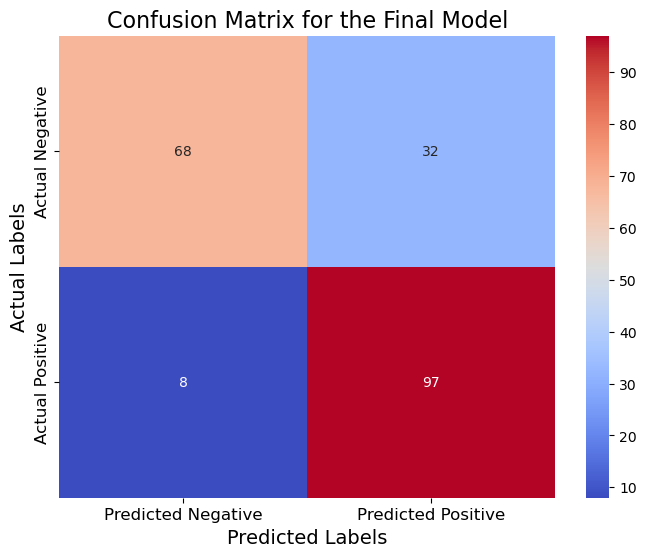

In [40]:
# Get the final model predictions on the testing set.
modtester = SugenoFISTester(model, X_test_final, final_feature_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs, axis = 1)

# Compute the test perfomance metrics for the final model.
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# Print the test performance metrics for the final model.
print('Test performance metrics for the final model:')
print(f'- Accuracy: {acc:.3f}')
print(f'- Recall: {rec:.3f}')
print(f'- Precision: {prec:.3f}')
print(f'- F1-Score: {F1_score:.3f}')
print(f'- Kappa Score: {kappa:.3f}')

# Compute the confusion matrix for the final model.
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix for the final model.
print(f'\nConfusion matrix for the final model:\n{cm}')

# Plot the confusion matrix for the final model.
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'coolwarm',
            xticklabels = ['Predicted Negative', 'Predicted Positive'],
            yticklabels = ['Actual Negative', 'Actual Positive'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted Labels', fontsize = 14)
plt.ylabel('Actual Labels', fontsize = 14)
plt.title('Confusion Matrix for the Final Model', fontsize = 16)
plt.show()